In [7]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler,BucketedRandomProjectionLSH   
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix



In [2]:
# read training and test data from csv files
TRAINING_PATH = "./train_selected.csv"
TESTING_PATH = "./test_selected.csv"

In [3]:

spark = SparkSession.builder.appName("KNN").getOrCreate()
sc = spark.sparkContext

In [4]:
training_rdd = spark.read.csv(TRAINING_PATH, header=True, inferSchema=True)
testing_rdd = spark.read.csv(TESTING_PATH, header=True, inferSchema=True)
# print dataset length
print("Training data length: ", training_rdd.count())
print("Testing data length: ", testing_rdd.count())

# print the count of label values in training data
training_rdd.groupBy("label").count().show()
testing_rdd.groupBy("label").count().show()

Training data length:  177041
Testing data length:  58329
+-----+------+
|label| count|
+-----+------+
|    1|101480|
|    0| 75561|
+-----+------+

+-----+-----+
|label|count|
+-----+-----+
|    1|33370|
|    0|24959|
+-----+-----+



In [15]:
training_rdd.printSchema()

root
 |-- NoOfImage: integer (nullable = true)
 |-- URLSimilarityIndex: double (nullable = true)
 |-- NoOfJS: integer (nullable = true)
 |-- HasDescription: integer (nullable = true)
 |-- HasSocialNet: integer (nullable = true)
 |-- HasCopyrightInfo: integer (nullable = true)
 |-- IsHTTPS: integer (nullable = true)
 |-- label: integer (nullable = true)



In [5]:
#
# Specify the feature columns, excluding the label column
# feature_columns = [col for col in training_rdd.columns if col in [ "URLLength", "URLSimilarityIndex"]]
assembler = VectorAssembler(inputCols=training_rdd.columns, outputCol="features")

# Assemble features for both train and test datasets
train_df = assembler.transform(training_rdd).select("features", "label")
test_df = assembler.transform(testing_rdd).select("features", "label")

In [8]:

# Perform Cross-Validation
num_folds = 2
folds = np.array_split(training_rdd.collect(), num_folds)
accuracies = []

for i in range(num_folds):
    # Split into training and testing folds
    test_fold = spark.createDataFrame(folds[i])
    train_folds = [row for index, fold in enumerate(folds) if index != i for row in fold]
    train_fold = spark.createDataFrame(train_folds)

    # Train LSH model
    brp = BucketedRandomProjectionLSH(inputCol="features_vector", outputCol="hashes", bucketLength=2.0)
    model = brp.fit(train_fold)

    # Find nearest neighbors in the training data
    def classify(row):
        nearest = model.approxNearestNeighbors(train_fold, row["features_vector"], 3).collect()
        labels = [neighbor["label"] for neighbor in nearest]
        return max(set(labels), key=labels.count)

    # Apply classification
    results = test_fold.rdd.map(lambda row: (row["id"], row["label"], classify(row))).toDF(["id", "true_label", "prediction"])

    # Evaluate
    predictions = results.select("true_label", "prediction").toPandas()
    accuracy = accuracy_score(predictions["true_label"], predictions["prediction"])
    accuracies.append(accuracy)

# Output the average accuracy
average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average Cross-Validation Accuracy: {average_accuracy:.4f}")

PySparkTypeError: [CANNOT_INFER_SCHEMA_FOR_TYPE] Can not infer schema for type: `ndarray`.

In [12]:

# Evaluate the model using accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy:.4f}")

# Evaluate the model using additional metrics
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
print(f"Test Precision = {precision:.4f}")

recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)
print(f"Test Recall = {recall:.4f}")

f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = f1_evaluator.evaluate(predictions)
print(f"Test F1 Score = {f1:.4f}")

# Plot confusion matrix
predictions.groupBy("label", "prediction").count().show()


Test Accuracy = 0.9862
Test Precision = 0.9865
Test Recall = 0.9862
Test F1 Score = 0.9862
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|24155|
|    1|       1.0|33370|
|    0|       1.0|  804|
+-----+----------+-----+



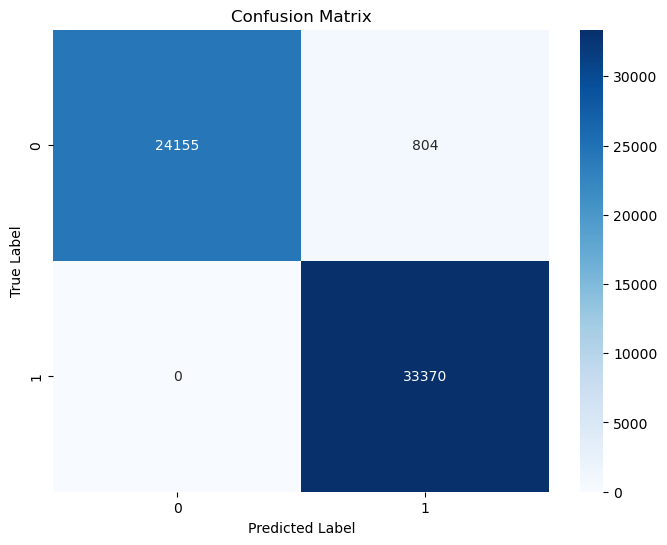

In [13]:
#  Plot confusion matrix using sklearn
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()